## Setup

In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
path = "../Data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"

train, test = 5e4, 5e4
minimum_sig_ration = 0.50

In [20]:
file = uproot.open(path)
T = file['tree']


df = T.pandas.df("v0_rxy v0_chi2 cosTheta v0_ks_mass trueKs".split(" "), entrystop = train)


means, stds = [], []

# Normalize:
for col in df.columns[:-1]:
    means.append(df[col].mean())
    stds.append(df[col].std())
    df[col] = (df[col] - df[col].mean()) / df[col].std() 
    
total_sig_noise = (df['trueKs'] == 1).sum() / (df['trueKs'] == 0).sum()
total_sig = (df['trueKs'] == 1).sum()

## Functions
We want to make an optimizer for finding the best signal to noise ratio

In [21]:
# the variables are gonna be: rxy_low, rxy_high, chi2_high, cosTheta_low, mass_low, mass_high

def signal_to_noise(x):
    rxy_low, rxy_high, chi2_high, cosTheta_low, mass_low, mass_high = x
    
    cop = df.copy()
    
    cop = cop.loc[np.logical_and(cop['v0_rxy'] > rxy_low, cop['v0_rxy'] < rxy_high)]
    cop = cop.loc[cop['v0_chi2'] < chi2_high]
    cop = cop.loc[cop['cosTheta'] > cosTheta_low]
    cop = cop.loc[np.logical_and(cop['v0_ks_mass'] > mass_low, cop['v0_ks_mass'] < mass_high)]
    
    return -(cop['trueKs'] == 1).sum() / (cop['trueKs'] == 0).sum()


def amount_of_signal(x):
    rxy_low, rxy_high, chi2_high, cosTheta_low, mass_low, mass_high = x
    
    cop = df.copy()
    
    cop = cop.loc[np.logical_and(cop['v0_rxy'] > rxy_low, cop['v0_rxy'] < rxy_high)]
    cop = cop.loc[cop['v0_chi2'] < chi2_high]
    cop = cop.loc[cop['cosTheta'] > cosTheta_low]
    cop = cop.loc[np.logical_and(cop['v0_ks_mass'] > mass_low, cop['v0_ks_mass'] < mass_high)]
    
    return (cop['trueKs'] == 1).sum()

## Minimize

In [22]:
# Guesses:
rxy_low, rxy_high = -1, 1
chi2_high = 0
cosTheta_low = 0
mass_low, mass_high = -1, 1

# In vector
x0 = [rxy_low, rxy_high, chi2_high, cosTheta_low, mass_low, mass_high]

In [23]:
# Set the least amount of acceptet signal
# we want to keep at least half of the original signal
minimum_signal = total_sig *  minimum_sig_ration


In [24]:
from scipy.optimize import minimize

In [25]:
y = minimize(lambda x: signal_to_noise(x), x0 = x0, \
         options = {'eps': 0.005}, \
         constraints = {'type': "ineq", 'fun': lambda x:  amount_of_signal(x) - minimum_signal})

/home/johann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


In [26]:
sig_to_noise = -y.fun
sig_amount   = amount_of_signal(y.x)

In [27]:
rxy_low, rxy_high, chi2_high, cosTheta_low, mass_low, mass_high = y.x

rxy_low_min = (rxy_low * stds[0]) + means[0]
rxy_high_min = (rxy_high * stds[0]) + means[0]
chi2_high_min = (chi2_high * stds[1]) + means[1]
cos_Theta_low_min = (cosTheta_low * stds[2]) + means[2] 
mass_low_min = (mass_low * stds[3]) + means[3]
mass_high_min = (mass_high * stds[3]) + means[3]

In [28]:
cut_string = f"""
The new cuts are: rxy between {rxy_low_min:.3f} and {rxy_high_min:.3f}
For chi2 it is lower than {chi2_high_min:.3f}
For cosTheta, the cut is over {cos_Theta_low_min:.4f}
For mass it is between {mass_low_min:.3f} and {mass_high_min:.3f}

In train data we have:
signal to noise is {sig_to_noise:.2f}, up from {total_sig_noise:.2f}
Amount of signal is {sig_amount}, down from {total_sig}
"""

print(cut_string)


The new cuts are: rxy between -60.818 and 114.783
For chi2 it is lower than 0.819
For cosTheta, the cut is over 0.2705
For mass it is between 490.454 and 510.894

In train data we have:
signal to noise is 7.26, up from 0.10
Amount of signal is 2380, down from 4739



## In test data

In [29]:
df_test = T.pandas.df("v0_rxy v0_chi2 cosTheta v0_ks_mass trueKs".split(" "), entrystart = train, entrystop = test + train)

total_test_sig = (df_test['trueKs'] == 1).sum()
total_sig_noise_test = (df_test['trueKs'] == 1).sum() / (df_test['trueKs'] == 0).sum()
# print(total_test_sig)

df_test = df_test.loc[np.logical_and(df_test['v0_rxy'] > rxy_low_min, df_test['v0_rxy'] < rxy_high_min)]
df_test = df_test.loc[df_test['v0_chi2'] < chi2_high_min]
df_test = df_test.loc[df_test['cosTheta'] > cos_Theta_low_min]
df_test = df_test.loc[np.logical_and(df_test['v0_ks_mass'] > mass_low_min, df_test['v0_ks_mass'] < mass_high_min)]



In [30]:
sig_noise_test, sig_test_after = (df_test['trueKs'] == 1).sum() / (df_test['trueKs'] == 0).sum(), (df_test['trueKs'] == 1).sum()

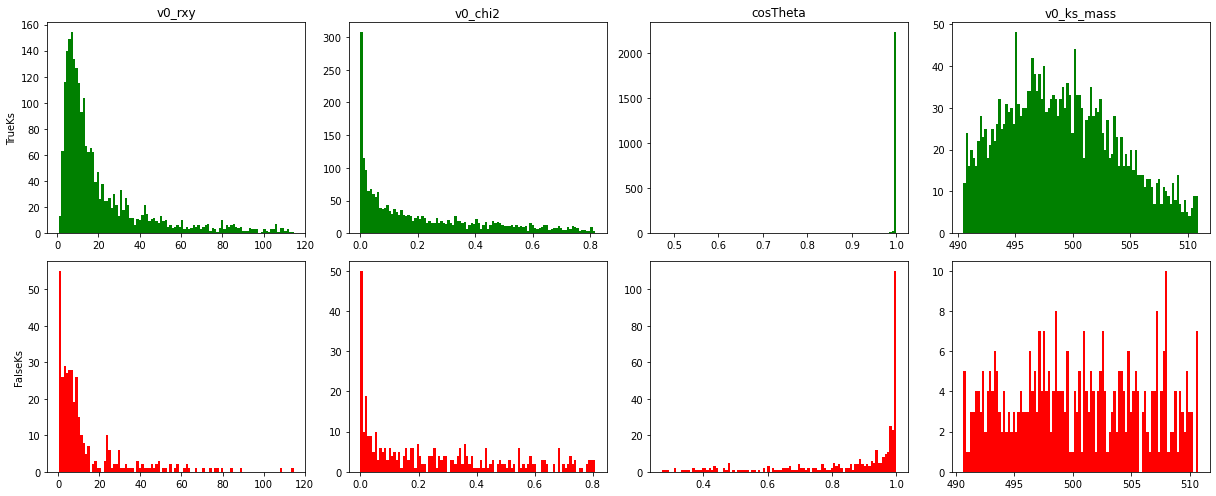

In [31]:
fig, ax = plt.subplots(ncols = 4, nrows = 2, figsize = (17, 7))
bins = 100

plot_values = "v0_rxy v0_chi2 cosTheta v0_ks_mass".split(" ") # Values to plot 
trueKs = df_test["trueKs"].astype(bool) # Identify true/false for Ks 

for i, col in enumerate(plot_values):
    ax[0][i].set_title(col)
    ax[0][i].hist(df_test[col].loc[trueKs], bins = bins, color = "green")
    ax[1][i].hist(df_test[col].loc[trueKs.apply(lambda x: not x)], bins = bins, color = "red")
    
ax[0][0].set_ylabel("TrueKs")
ax[1][0].set_ylabel("FalseKs")

fig.tight_layout()

In [32]:
test_data_string = f"""
In test data, we have:
signal to noise is {sig_noise_test:.2f}, up from {total_sig_noise_test:.2f}
Amount of signal is {sig_test_after}, down from {total_test_sig}
"""
print(test_data_string)


In test data, we have:
signal to noise is 6.22, up from 0.10
Amount of signal is 2272, down from 4625



In [33]:
def cutter(df):
    label = np.ones(len(df))
    label[np.logical_or(df['v0_rxy'] < rxy_low_min, df['v0_rxy'] > rxy_high_min)] = 0
    label[df['v0_chi2'] > chi2_high_min] = 0
    label[df['cosTheta'] < cos_Theta_low_min] = 0
    label[np.logical_or(df['v0_ks_mass'] < mass_low_min, df['v0_ks_mass'] > mass_high_min)] = 0
    return label

In [34]:
import dill, pickle

In [35]:
file = open(f"cutter_{int(100 * minimum_sig_ration)}.dat", 'wb')
seriealized = dill.dumps(cutter, recurse = True)
dill.dump(seriealized, file, recurse = True)
file.close()
